In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from scipy.stats import cauchy
import random
import sympy as sp
from scipy.optimize import fsolve
import matplotlib.patches as mpatches
from scipy.signal import find_peaks
from matplotlib.lines import Line2D

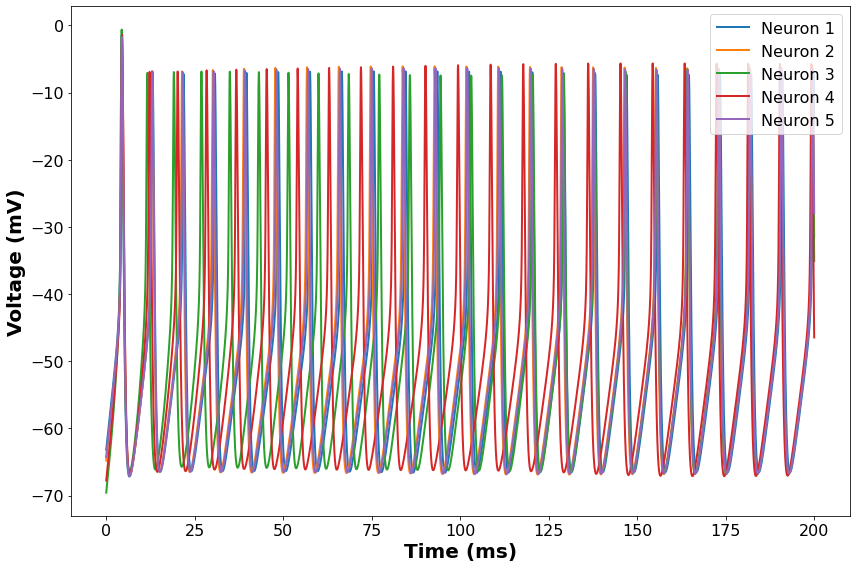

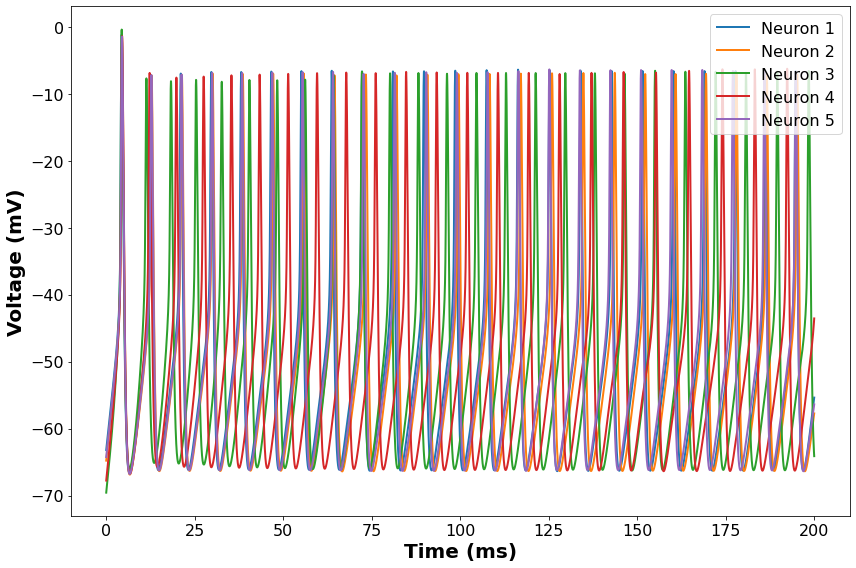

In [95]:
N       = 5
C       = 1.0
Esyn    = -80.0
K       = 0.1               # global synaptic‐strength so that K·g_static = 0.1
gmin    = 0.0
gmax    = 1.0
A_plus  = A_minus  = 2.0
tau_plus= tau_minus = 10.0
tc      = 3.0               # STDP time window (ms)

t_total = 200.0
dt      = 0.001
t_eval  = np.arange(0, t_total, dt)

# ionic reversal potentials & conductances
EL, ENa, EK, ET = -70.0, 50.0, -90.0, 0.0
gL, gNa, gK, gT = 0.05, 3.0, 5.0, 5.0

# baseline currents (homogeneous here)
I_stim = np.full(N, 5.0)
#I_stim = np.random.uniform(4.84, 5.16, size=N) # Heterogeneous

def h_inf(V):    return 1/(1+np.exp((V+41)/4))
def r_inf(V):    return 1/(1+np.exp((V+84)/4))
def m_inf(V):    return 1/(1+np.exp(-(V+37)/7))
def p_inf(V):    return 1/(1+np.exp(-(V+60)/6.2))
def alpha_h(V):  return 0.128*np.exp(-(V+46)/18)
def beta_h(V):   return 4/(1+np.exp(-(V+23)/5))
def tau_h(V):    return 1/(alpha_h(V)+beta_h(V))
def tau_r(V):    return 28 + np.exp(-(V+25)/10.5)

def ds_dt(V, s, c1=3.0, c2=0.3, VT=-20.0, sigma=0.8):
    return c1*(1-s)/(1+np.exp(-(V-VT)/sigma)) - c2*s

# ionic currents
def I_L(V):     return gL*(V-EL)
def I_Na(V,h):  return gNa*(m_inf(V)**3)*h*(V-ENa)
def I_K(V,h):   return gK*((0.75*(1-h))**4)*(V-EK)
def I_T(V,r):   return gT*(p_inf(V)**2)*r*(V-ET)

# STDP update
def stdp_update(g, delta_t):
    if 0 < delta_t < tc:
        return np.clip(g + A_plus*(1-g)*np.exp(-delta_t/tau_plus), gmin, gmax)
    elif -tc < delta_t <= 0:
        return np.clip(g - A_minus*(g-gmin)*np.exp(delta_t/tau_minus), gmin, gmax)
    else:
        return g


def full_model(t, y, g_matrix):
    V, h, r, s = np.split(y, 4)
    dV = np.zeros(N)
    dh = np.zeros(N)
    dr = np.zeros(N)
    ds = np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i],h[i]) + I_K(V[i],h[i]) + I_T(V[i],r[i])
        # note the K factor here:
        Isyn = K * sum(g_matrix[i,j]*s[j]*(V[i]-Esyn) for j in range(N) if j!=i)/(N-1)
        dV[i] = ( - Iion + I_stim[i] - Isyn )/C
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = ds_dt(V[i], s[i])
    return np.concatenate([dV, dh, dr, ds])


V0 = np.random.uniform(-70,-60, N)
h0 = h_inf(V0)
r0 = r_inf(V0)
s0 = np.zeros(N)
y0 = np.concatenate([V0,h0,r0,s0])


g_static = np.ones((N,N))
np.fill_diagonal(g_static, 0.0)

sol_static = np.zeros((4*N, len(t_eval)))
y = y0.copy()
sol_static[:,0] = y
for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_static)
    y  = y + dy*dt
    sol_static[:,k+1] = y


g_dynamic  = g_static.copy()      # start from same baseline
last_spikes= np.full(N, -1e6)     # far in the past
V_prev      = y0[:N].copy()

Y_stdp = np.zeros((4*N, len(t_eval)))
y = y0.copy()
Y_stdp[:,0] = y

for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_dynamic)
    y  = y + dy*dt

    V = y[:N]

    # threshold‐crossing with positive slope:
    for i in range(N):
        if V_prev[i] < -30 <= V[i] and (V[i]-V_prev[i])>0 and (t - last_spikes[i])>tc:
            # neuron i has just spiked
            for j in range(N):
                if i==j: continue
                # 1) update synapse j -> i  (post = i, pre = j)
                dt_ji = t - last_spikes[j]
                g_dynamic[i,j] = stdp_update(g_dynamic[i,j], dt_ji)
                # 2) update synapse i -> j  (post = j, pre = i)
                dt_ij = last_spikes[j] - t
                g_dynamic[j,i] = stdp_update(g_dynamic[j,i], dt_ij)
            last_spikes[i] = t

    V_prev = V.copy()
    Y_stdp[:,k+1] = y


plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, sol_static[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("Without Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('WithoutSTDPInhibitory.png')
plt.show()

plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, Y_stdp[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("With Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('WithSTDPInhibitory.png')
plt.show()


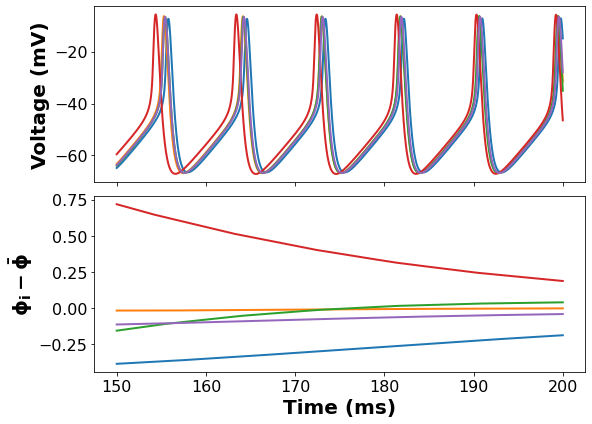

In [100]:

# Phase extraction
phi = np.zeros((N, len(t_eval)))
for i in range(N):
    crosses = np.where((sol_static[i,:-1] < -30) & (sol_static[i,1:] >= -30))[0] + 1
    times   = t_eval[crosses]
    for j in range(len(times)-1):
        t0, t1 = times[j], times[j+1]
        idxs = np.where((t_eval >= t0) & (t_eval < t1))[0]
        phi[i, idxs] = 2*np.pi * (t_eval[idxs] - t0) / (t1 - t0)
    if len(times) > 1:
        period = times[-1] - times[-2]
        idxs = np.where(t_eval >= times[-1])[0]
        phi[i, idxs] = 2*np.pi * (t_eval[idxs] - times[-1]) / period

phi_bar = np.angle(np.mean(np.exp(1j*phi), axis=0))
phi_dev = np.angle(np.exp(1j*(phi - phi_bar)))

# Focused time window for plotting
start = int(150/dt)
end = int(200/dt)
t_win = t_eval[start:end]
V_win = sol_static[:N, start:end]
phi_win = phi_dev[:, start:end]

fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True)
colors = plt.cm.tab10(np.arange(N))

for i in range(N):
    axes[0].plot(t_win, V_win[i], color=colors[i], lw=2)
axes[0].set_ylabel("Voltage (mV)", fontweight = 'bold', fontsize = 20)
axes[0].tick_params(axis='both', labelsize=16)

for i in range(N):
    axes[1].plot(t_win, phi_win[i], color=colors[i], lw=2)
axes[1].set_xlabel("Time (ms)", fontweight = 'bold', fontsize = 20)
axes[1].set_ylabel(r"$\mathbf{\phi_i - \bar\phi}$", fontsize = 20)
axes[1].tick_params(axis='both', labelsize=16)

plt.tight_layout()
fig.savefig("voltage_phase_static_inhibitory.png")
plt.show()


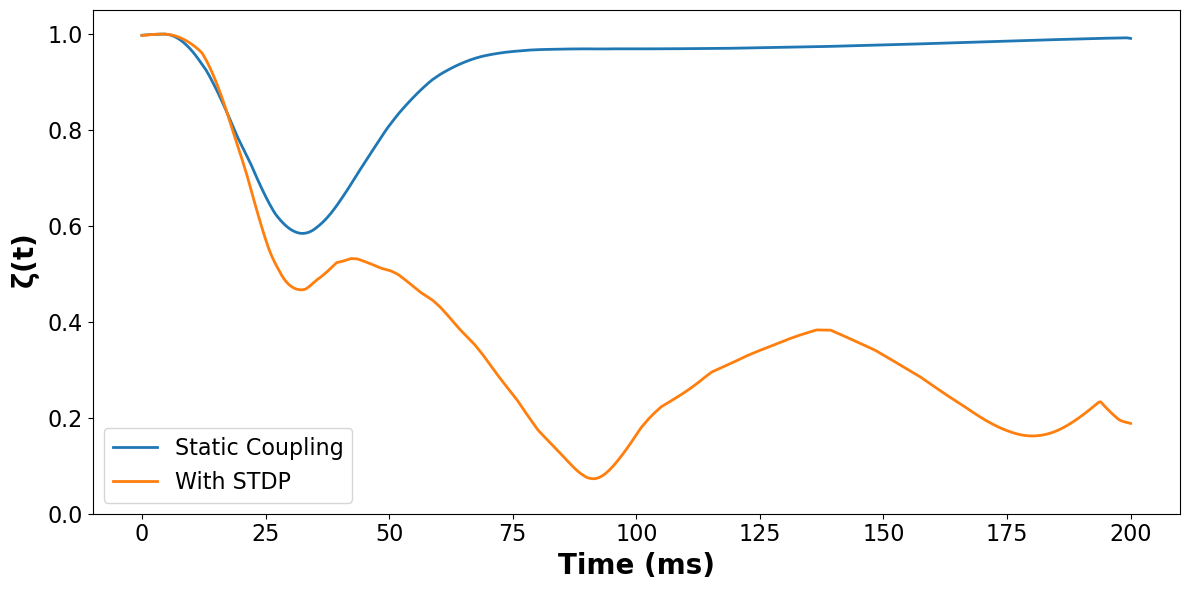

In [123]:
def compute_phases_and_R(V_traces, t_eval, thresh=-30.0):
    N, T = V_traces.shape
    phases = np.zeros((N, T))
    
    # 1) detect spike times and mean ISI per neuron
    spike_times = []
    mean_ISI     = np.zeros(N)
    for i in range(N):
        # rising threshold crossings
        idx = np.where((V_traces[i,:-1] < thresh) & (V_traces[i,1:] >= thresh))[0]
        st = t_eval[idx]
        spike_times.append(st)
        if len(st) > 1:
            mean_ISI[i] = np.mean(np.diff(st))
        else:
            mean_ISI[i] = t_eval[-1]  # fallback if only 1 spike

    # 2) build a continuous phase by linear interpolation across an extended spike train
    for i in range(N):
        st = spike_times[i]
        isi = mean_ISI[i]
        # pad beginning and end so we cover [0, t_total]
        ext = np.concatenate(([st[0]-isi], st, [st[-1]+isi]))
        for k in range(len(ext)-1):
            t0, t1 = ext[k], ext[k+1]
            mask = (t_eval >= t0) & (t_eval < t1)
            phases[i,mask] = 2*np.pi * (t_eval[mask] - t0) / (t1 - t0)

    # 3) compute R(t)
    R = np.abs(np.sum(np.exp(1j * phases), axis=0) / N)
    return phases, R

# Extract voltage traces (rows 0..N-1 of your solution arrays)
V_static = sol_static[:N, :]   # shape (N, len(t_eval))
V_stdp   = Y_stdp[:N,   :]

# Compute phases and R
_, R_static = compute_phases_and_R(V_static, t_eval)
_, R_stdp   = compute_phases_and_R(V_stdp,   t_eval)

# 4) plot
plt.figure(figsize=(12,6))
plt.plot(t_eval, R_static, label='Static Coupling', linewidth=2)
plt.plot(t_eval, R_stdp,   label='With STDP',     linewidth=2)
plt.xlabel("Time (ms)",           fontsize=20, fontweight = 'bold')
plt.ylabel(r"$\mathbf{\zeta(t)}$",     fontsize=20, fontweight = 'bold')
plt.ylim(0, 1.05)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('KuramatoInhib.png')
plt.show()


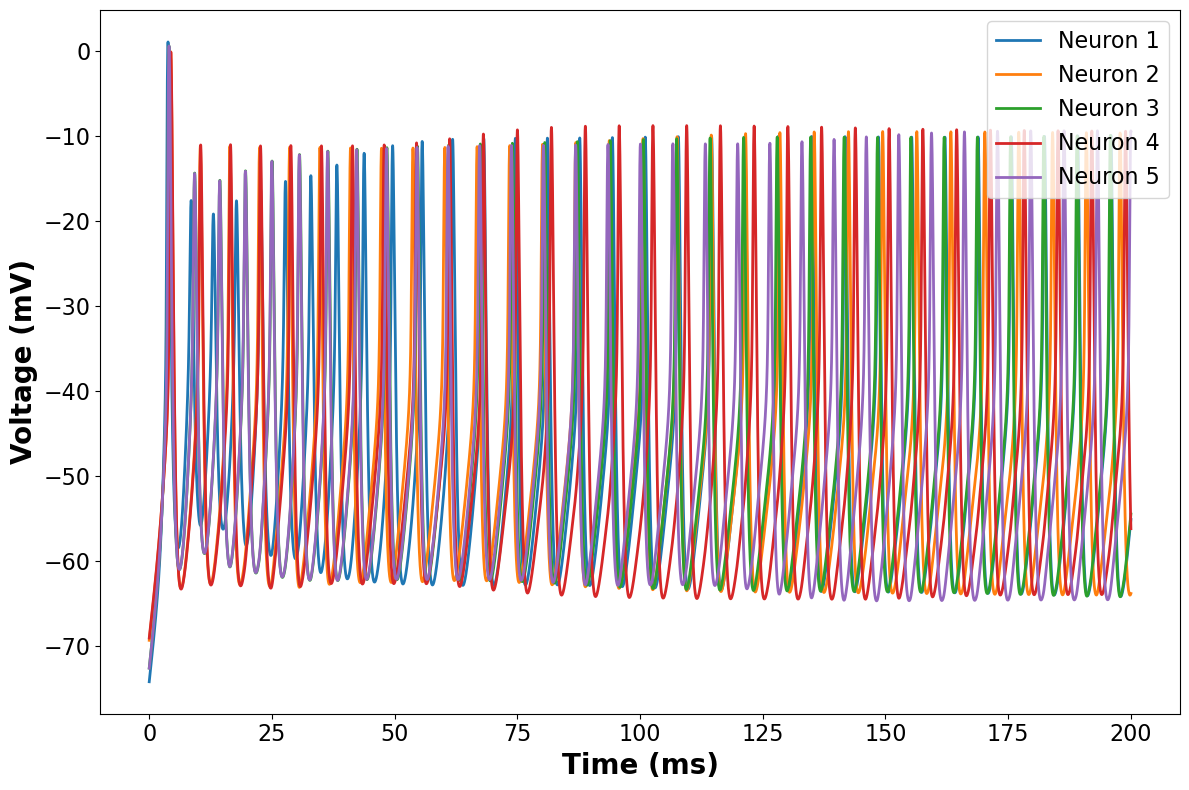

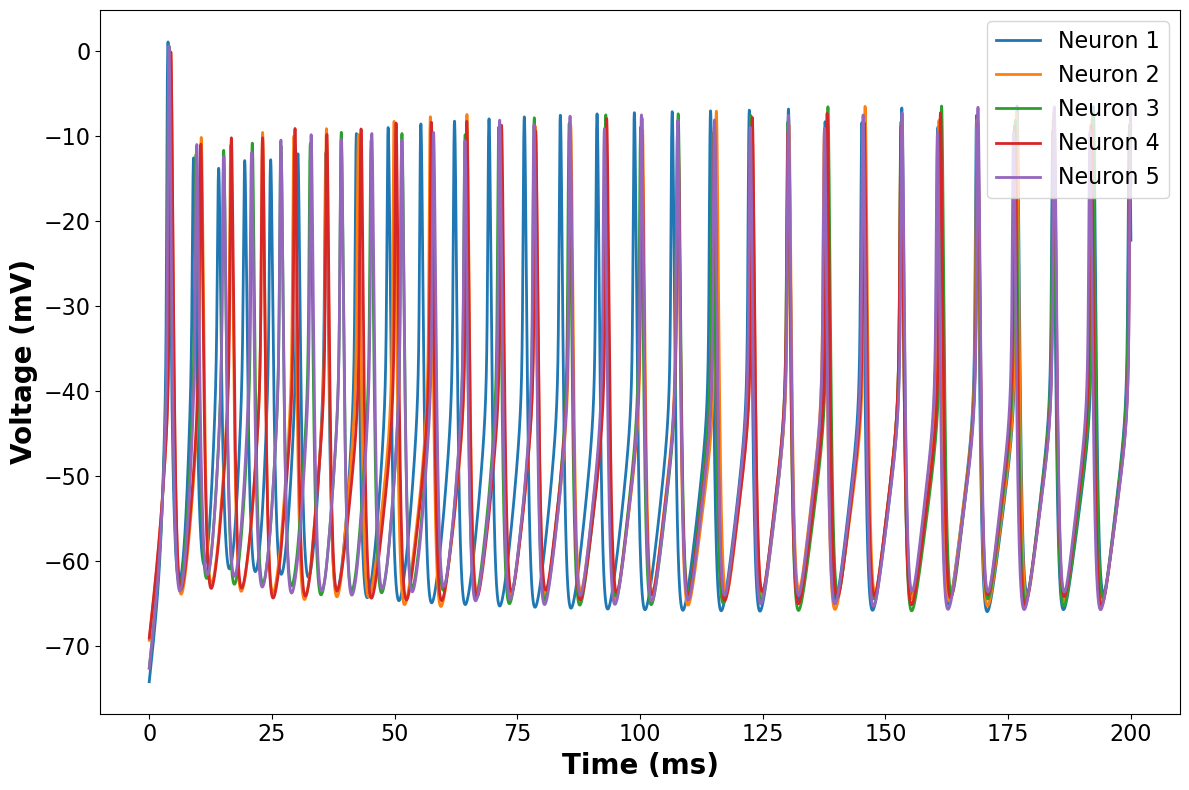

In [127]:
N       = 5
C       = 1.0
Esyn    = 0
K       = 0.1               # global synaptic‐strength so that K·g_static = 0.1
gmin    = 0.0
gmax    = 1.0
A_plus  = A_minus  = 2.0
tau_plus= tau_minus = 10.0
tc      = 3.0               # STDP time window (ms)

t_total = 200.0
dt      = 0.001
t_eval  = np.arange(0, t_total, dt)

# ionic reversal potentials & conductances
EL, ENa, EK, ET = -70.0, 50.0, -90.0, 0.0
gL, gNa, gK, gT = 0.05, 3.0, 5.0, 5.0

# baseline currents (homogeneous here)
I_stim = np.full(N, 5.0)
#I_stim = np.random.uniform(4.84, 5.16, size=N) # Heterogeneous

def h_inf(V):    return 1/(1+np.exp((V+41)/4))
def r_inf(V):    return 1/(1+np.exp((V+84)/4))
def m_inf(V):    return 1/(1+np.exp(-(V+37)/7))
def p_inf(V):    return 1/(1+np.exp(-(V+60)/6.2))
def alpha_h(V):  return 0.128*np.exp(-(V+46)/18)
def beta_h(V):   return 4/(1+np.exp(-(V+23)/5))
def tau_h(V):    return 1/(alpha_h(V)+beta_h(V))
def tau_r(V):    return 28 + np.exp(-(V+25)/10.5)

def ds_dt(V, s, c1=3.0, c2=0.3, VT=-20.0, sigma=0.8):
    return c1*(1-s)/(1+np.exp(-(V-VT)/sigma)) - c2*s

# ionic currents
def I_L(V):     return gL*(V-EL)
def I_Na(V,h):  return gNa*(m_inf(V)**3)*h*(V-ENa)
def I_K(V,h):   return gK*((0.75*(1-h))**4)*(V-EK)
def I_T(V,r):   return gT*(p_inf(V)**2)*r*(V-ET)

# STDP update
def stdp_update(g, delta_t):
    if 0 < delta_t < tc:
        return np.clip(g + A_plus*(1-g)*np.exp(-delta_t/tau_plus), gmin, gmax)
    elif -tc < delta_t <= 0:
        return np.clip(g - A_minus*(g-gmin)*np.exp(delta_t/tau_minus), gmin, gmax)
    else:
        return g


def full_model(t, y, g_matrix):
    V, h, r, s = np.split(y, 4)
    dV = np.zeros(N)
    dh = np.zeros(N)
    dr = np.zeros(N)
    ds = np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i],h[i]) + I_K(V[i],h[i]) + I_T(V[i],r[i])
        # note the K factor here:
        Isyn = K * sum(g_matrix[i,j]*s[j]*(V[i]-Esyn) for j in range(N) if j!=i)/(N-1)
        dV[i] = ( - Iion + I_stim[i] - Isyn )/C
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = ds_dt(V[i], s[i])
    return np.concatenate([dV, dh, dr, ds])


V0 = np.random.uniform(-75,-55, N)
h0 = h_inf(V0)
r0 = r_inf(V0)
s0 = np.zeros(N)
y0 = np.concatenate([V0,h0,r0,s0])


g_static = np.ones((N,N))
np.fill_diagonal(g_static, 0.0)

sol_static = np.zeros((4*N, len(t_eval)))
y = y0.copy()
sol_static[:,0] = y
for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_static)
    y  = y + dy*dt
    sol_static[:,k+1] = y


g_dynamic  = g_static.copy()      # start from same baseline
last_spikes= np.full(N, -1e6)     # far in the past
V_prev      = y0[:N].copy()

Y_stdp = np.zeros((4*N, len(t_eval)))
y = y0.copy()
Y_stdp[:,0] = y

for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_dynamic)
    y  = y + dy*dt

    V = y[:N]

    # threshold‐crossing with positive slope:
    for i in range(N):
        if V_prev[i] < -30 <= V[i] and (V[i]-V_prev[i])>0 and (t - last_spikes[i])>tc:
            # neuron i has just spiked
            for j in range(N):
                if i==j: continue
                # 1) update synapse j -> i  (post = i, pre = j)
                dt_ji = t - last_spikes[j]
                g_dynamic[i,j] = stdp_update(g_dynamic[i,j], dt_ji)
                # 2) update synapse i -> j  (post = j, pre = i)
                dt_ij = last_spikes[j] - t
                g_dynamic[j,i] = stdp_update(g_dynamic[j,i], dt_ij)
            last_spikes[i] = t

    V_prev = V.copy()
    Y_stdp[:,k+1] = y


plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, sol_static[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("Without Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('WithoutSTDPExcitatory.png')
plt.show()

plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, Y_stdp[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("With Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('WithSTDPExcitatory.png')
plt.show()


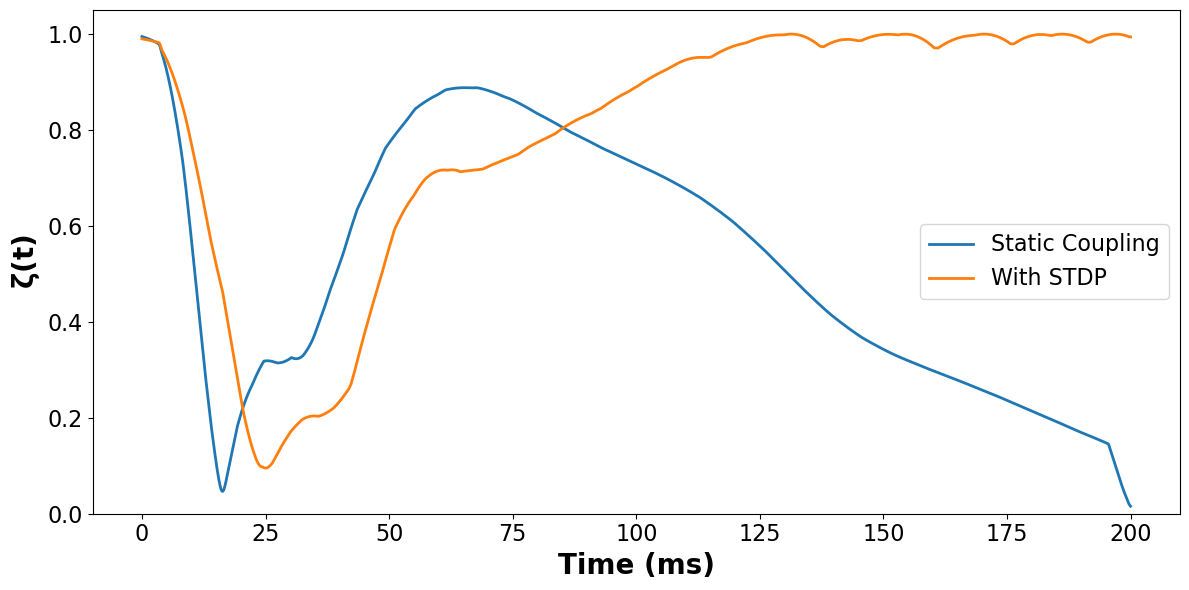

In [128]:
def compute_phases_and_R(V_traces, t_eval, thresh=-30.0):
    
    N, T = V_traces.shape
    phases = np.zeros((N, T))
    
    # 1) detect spike times and mean ISI per neuron
    spike_times = []
    mean_ISI     = np.zeros(N)
    for i in range(N):
        # rising threshold crossings
        idx = np.where((V_traces[i,:-1] < thresh) & (V_traces[i,1:] >= thresh))[0]
        st = t_eval[idx]
        spike_times.append(st)
        if len(st) > 1:
            mean_ISI[i] = np.mean(np.diff(st))
        else:
            mean_ISI[i] = t_eval[-1]  # fallback if only 1 spike

    # 2) build a continuous phase by linear interpolation across an extended spike train
    for i in range(N):
        st = spike_times[i]
        isi = mean_ISI[i]
        # pad beginning and end so we cover [0, t_total]
        ext = np.concatenate(([st[0]-isi], st, [st[-1]+isi]))
        for k in range(len(ext)-1):
            t0, t1 = ext[k], ext[k+1]
            mask = (t_eval >= t0) & (t_eval < t1)
            phases[i,mask] = 2*np.pi * (t_eval[mask] - t0) / (t1 - t0)

    # 3) compute R(t)
    R = np.abs(np.sum(np.exp(1j * phases), axis=0) / N)
    return phases, R

# Extract voltage traces (rows 0..N-1 of your solution arrays)
V_static = sol_static[:N, :]   # shape (N, len(t_eval))
V_stdp   = Y_stdp[:N,   :]

# Compute phases and R
_, R_static = compute_phases_and_R(V_static, t_eval)
_, R_stdp   = compute_phases_and_R(V_stdp,   t_eval)

# 4) plot
plt.figure(figsize=(12,6))
plt.plot(t_eval, R_static, label='Static Coupling', linewidth=2)
plt.plot(t_eval, R_stdp,   label='With STDP',     linewidth=2)
plt.xlabel("Time (ms)",           fontsize=20, fontweight = 'bold')
plt.ylabel(r"$\mathbf{\zeta(t)}$",     fontsize=20, fontweight = 'bold')
plt.ylim(0, 1.05)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('KuramatoExcit.png')
plt.show()


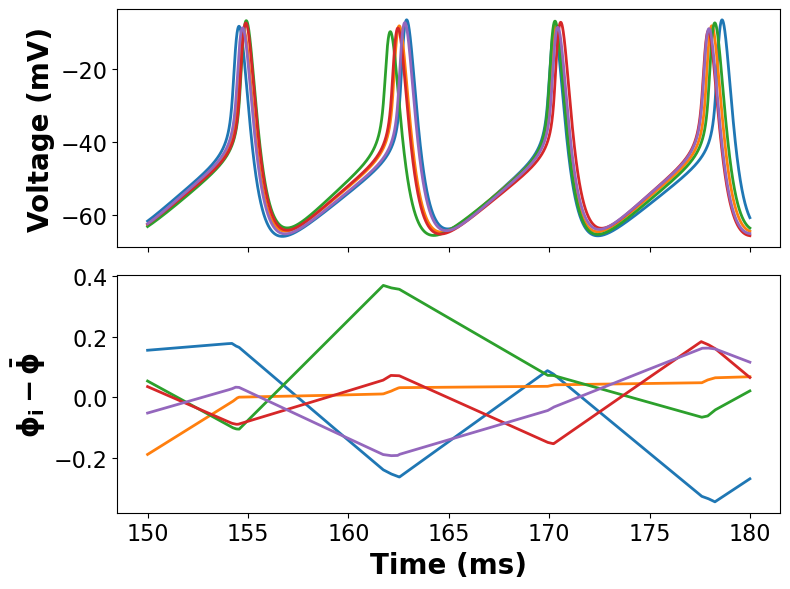

In [129]:

N       = 5
C       = 1.0
Esyn    = 0.0
K       = 0.1
gmin    = 0.0
gmax    = 1.0
A_plus  = A_minus  = 2.0
tau_plus= tau_minus = 10.0
tc      = 3.0               # STDP window (ms)

t_total = 200.0
dt      = 0.001
t_eval  = np.arange(0, t_total, dt)

# Reversal potentials & conductances
EL, ENa, EK, ET = -70.0, 50.0, -90.0, 0.0
gL, gNa, gK, gT = 0.05, 3.0, 5.0, 5.0

# Baseline current
I_stim = np.full(N, 5.0)


def h_inf(V):    return 1/(1+np.exp((V+41)/4))
def r_inf(V):    return 1/(1+np.exp((V+84)/4))
def m_inf(V):    return 1/(1+np.exp(-(V+37)/7))
def p_inf(V):    return 1/(1+np.exp(-(V+60)/6.2))
def alpha_h(V):  return 0.128*np.exp(-(V+46)/18)
def beta_h(V):   return 4/(1+np.exp(-(V+23)/5))
def tau_h(V):    return 1/(alpha_h(V)+beta_h(V))
def tau_r(V):    return 28 + np.exp(-(V+25)/10.5)

def ds_dt(V, s, c1=3.0, c2=0.3, VT=-20.0, sigma=0.8):
    return c1*(1-s)/(1+np.exp(-(V-VT)/sigma)) - c2*s

# Ionic currents
def I_L(V):     return gL*(V-EL)
def I_Na(V,h):  return gNa*(m_inf(V)**3)*h*(V-ENa)
def I_K(V,h):   return gK*((0.75*(1-h))**4)*(V-EK)
def I_T(V,r):   return gT*(p_inf(V)**2)*r*(V-ET)

# STDP update rule
def stdp_update(g, delta_t):
    if 0 < delta_t < tc:
        return np.clip(g + A_plus*(1-g)*np.exp(-delta_t/tau_plus), gmin, gmax)
    elif -tc < delta_t <= 0:
        return np.clip(g - A_minus*(g-gmin)*np.exp(delta_t/tau_minus), gmin, gmax)
    else:
        return g


def full_model(t, y, g_matrix):
    V, h, r, s = np.split(y, 4)
    dV = np.zeros(N)
    dh = np.zeros(N)
    dr = np.zeros(N)
    ds = np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i],h[i]) + I_K(V[i],h[i]) + I_T(V[i],r[i])
        Isyn = K * sum(g_matrix[i,j]*s[j]*(V[i]-Esyn) for j in range(N) if j!=i)/(N-1)
        dV[i] = ( - Iion + I_stim[i] - Isyn )/C
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = ds_dt(V[i], s[i])
    return np.concatenate([dV, dh, dr, ds])


V0 = np.random.uniform(-75, -55, N)
h0 = h_inf(V0)
r0 = r_inf(V0)
s0 = np.zeros(N)
y0 = np.concatenate([V0, h0, r0, s0])


g_dynamic   = np.ones((N,N))
np.fill_diagonal(g_dynamic, 0.0)
last_spikes = np.full(N, -1e6)
V_prev      = y0[:N].copy()

Y_stdp = np.zeros((4*N, len(t_eval)))
y = y0.copy()
Y_stdp[:,0] = y

for k, t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_dynamic)
    y  = y + dy*dt
    V  = y[:N]

    # STDP on upward threshold crossings
    for i in range(N):
        if V_prev[i] < -30 <= V[i] and (t - last_spikes[i]) > tc:
            for j in range(N):
                if i == j: continue
                dt_ji = t - last_spikes[j]
                g_dynamic[i,j] = stdp_update(g_dynamic[i,j], dt_ji)
                dt_ij = last_spikes[j] - t
                g_dynamic[j,i] = stdp_update(g_dynamic[j,i], dt_ij)
            last_spikes[i] = t

    V_prev = V.copy()
    Y_stdp[:,k+1] = y


phi = np.zeros((N, len(t_eval)))
for i in range(N):
    crosses = np.where((Y_stdp[i,:-1] < -30) & (Y_stdp[i,1:] >= -30))[0] + 1
    times   = t_eval[crosses]
    for j in range(len(times)-1):
        t0, t1 = times[j], times[j+1]
        idxs = np.where((t_eval >= t0) & (t_eval < t1))[0]
        phi[i, idxs] = 2*np.pi * (t_eval[idxs] - t0) / (t1 - t0)
    # extend last segment
    if len(times) > 1:
        period = times[-1] - times[-2]
        idxs = np.where(t_eval >= times[-1])[0]
        phi[i, idxs] = 2*np.pi * (t_eval[idxs] - times[-1]) / period

# Center around mean phase
phi_bar = np.angle(np.mean(np.exp(1j*phi), axis=0))
phi_dev = np.angle(np.exp(1j*(phi - phi_bar)))


start = int(150/dt); end = int(180/dt)
t_win = t_eval[start:end]
V_win = Y_stdp[:N, start:end]
phi_win = phi_dev[:, start:end]

fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True)
colors = plt.cm.tab10(np.arange(N))

for i in range(N):
    axes[0].plot(t_win, V_win[i], color=colors[i], lw=2)
axes[0].set_ylabel("Voltage (mV)", fontweight = 'bold', fontsize = '20')
axes[0].tick_params(axis='both', labelsize=16)
#axes[0].set_title("Full order model (150–180 ms)")

for i in range(N):
    axes[1].plot(t_win, phi_win[i], color=colors[i], lw=2)
axes[1].set_xlabel("Time (ms)", fontweight = 'bold', fontsize = '20')
axes[1].set_ylabel(r"$\mathbf{\phi_i - \bar\phi}$", fontsize = '20')
axes[1].tick_params(axis='both', labelsize=16)
#axes[1].set_title("Phase reduced model (150–180 ms)")

plt.tight_layout()
plt.tight_layout()
fig.savefig('voltage_phase.png')
plt.show()
plt.show()


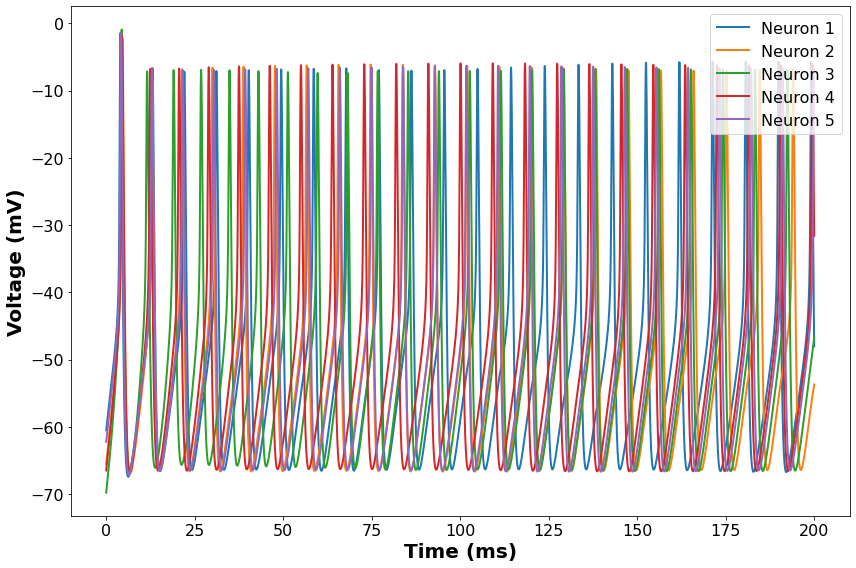

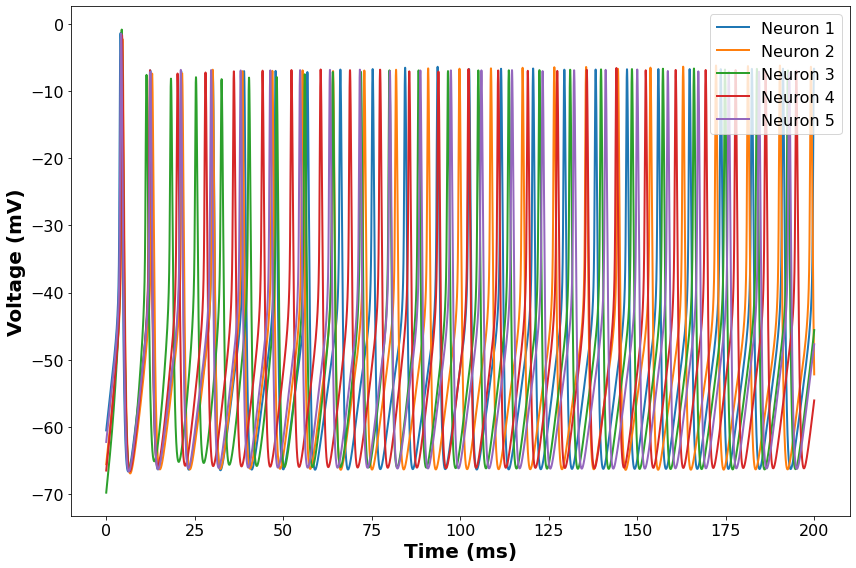

In [2]:
N       = 5
C       = 1.0
Esyn    = -80.0
K       = 0.1               # global synaptic‐strength so that K·g_static = 0.1
gmin    = 0.0
gmax    = 1.0
A_plus  = A_minus  = 2.0
tau_plus= tau_minus = 10.0
tc      = 3.0               # STDP time window (ms)

t_total = 200.0
dt      = 0.001
t_eval  = np.arange(0, t_total, dt)

# ionic reversal potentials & conductances
EL, ENa, EK, ET = -70.0, 50.0, -90.0, 0.0
gL, gNa, gK, gT = 0.05, 3.0, 5.0, 5.0

# baseline currents (homogeneous here)
#I_stim = np.full(N, 5.0)
I_stim = np.random.uniform(4.84, 5.16, size=N) # Heterogeneous

def h_inf(V):    return 1/(1+np.exp((V+41)/4))
def r_inf(V):    return 1/(1+np.exp((V+84)/4))
def m_inf(V):    return 1/(1+np.exp(-(V+37)/7))
def p_inf(V):    return 1/(1+np.exp(-(V+60)/6.2))
def alpha_h(V):  return 0.128*np.exp(-(V+46)/18)
def beta_h(V):   return 4/(1+np.exp(-(V+23)/5))
def tau_h(V):    return 1/(alpha_h(V)+beta_h(V))
def tau_r(V):    return 28 + np.exp(-(V+25)/10.5)

def ds_dt(V, s, c1=3.0, c2=0.3, VT=-20.0, sigma=0.8):
    return c1*(1-s)/(1+np.exp(-(V-VT)/sigma)) - c2*s

# ionic currents
def I_L(V):     return gL*(V-EL)
def I_Na(V,h):  return gNa*(m_inf(V)**3)*h*(V-ENa)
def I_K(V,h):   return gK*((0.75*(1-h))**4)*(V-EK)
def I_T(V,r):   return gT*(p_inf(V)**2)*r*(V-ET)

# STDP update
def stdp_update(g, delta_t):
    if 0 < delta_t < tc:
        return np.clip(g + A_plus*(1-g)*np.exp(-delta_t/tau_plus), gmin, gmax)
    elif -tc < delta_t <= 0:
        return np.clip(g - A_minus*(g-gmin)*np.exp(delta_t/tau_minus), gmin, gmax)
    else:
        return g

def full_model(t, y, g_matrix):
    V, h, r, s = np.split(y, 4)
    dV = np.zeros(N)
    dh = np.zeros(N)
    dr = np.zeros(N)
    ds = np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i],h[i]) + I_K(V[i],h[i]) + I_T(V[i],r[i])
        # note the K factor here:
        Isyn = K * sum(g_matrix[i,j]*s[j]*(V[i]-Esyn) for j in range(N) if j!=i)/(N-1)
        dV[i] = ( - Iion + I_stim[i] - Isyn )/C
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = ds_dt(V[i], s[i])
    return np.concatenate([dV, dh, dr, ds])

V0 = np.random.uniform(-70,-60, N)
h0 = h_inf(V0)
r0 = r_inf(V0)
s0 = np.zeros(N)
y0 = np.concatenate([V0,h0,r0,s0])

g_static = np.ones((N,N))
np.fill_diagonal(g_static, 0.0)

sol_static = np.zeros((4*N, len(t_eval)))
y = y0.copy()
sol_static[:,0] = y
for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_static)
    y  = y + dy*dt
    sol_static[:,k+1] = y

g_dynamic  = g_static.copy()      # start from same baseline
last_spikes= np.full(N, -1e6)     # far in the past
V_prev      = y0[:N].copy()

Y_stdp = np.zeros((4*N, len(t_eval)))
y = y0.copy()
Y_stdp[:,0] = y

for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_dynamic)
    y  = y + dy*dt

    V = y[:N]

    # threshold‐crossing with positive slope:
    for i in range(N):
        if V_prev[i] < -30 <= V[i] and (V[i]-V_prev[i])>0 and (t - last_spikes[i])>tc:
            # neuron i has just spiked
            for j in range(N):
                if i==j: continue
                # 1) update synapse j -> i  (post = i, pre = j)
                dt_ji = t - last_spikes[j]
                g_dynamic[i,j] = stdp_update(g_dynamic[i,j], dt_ji)
                # 2) update synapse i -> j  (post = j, pre = i)
                dt_ij = last_spikes[j] - t
                g_dynamic[j,i] = stdp_update(g_dynamic[j,i], dt_ij)
            last_spikes[i] = t

    V_prev = V.copy()
    Y_stdp[:,k+1] = y

plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, sol_static[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("Without Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('WithoutSTDPInhibitory_Heterogeneous.png')
plt.show()

plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, Y_stdp[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("With Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('WithSTDPInhibitory_Heterogeneous.png')
plt.show()


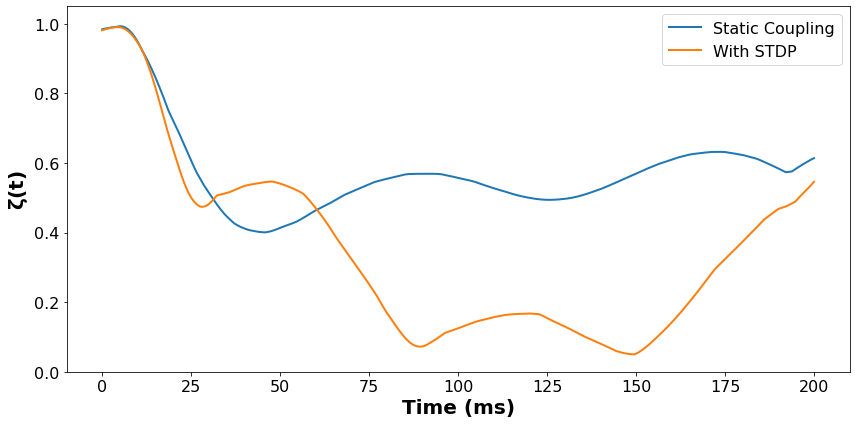

In [3]:
def compute_phases_and_R(V_traces, t_eval, thresh=-30.0):
    
    N, T = V_traces.shape
    phases = np.zeros((N, T))
    
    # 1) detect spike times and mean ISI per neuron
    spike_times = []
    mean_ISI     = np.zeros(N)
    for i in range(N):
        # rising threshold crossings
        idx = np.where((V_traces[i,:-1] < thresh) & (V_traces[i,1:] >= thresh))[0]
        st = t_eval[idx]
        spike_times.append(st)
        if len(st) > 1:
            mean_ISI[i] = np.mean(np.diff(st))
        else:
            mean_ISI[i] = t_eval[-1]  # fallback if only 1 spike

    # 2) build a continuous phase by linear interpolation across an extended spike train
    for i in range(N):
        st = spike_times[i]
        isi = mean_ISI[i]
        # pad beginning and end so we cover [0, t_total]
        ext = np.concatenate(([st[0]-isi], st, [st[-1]+isi]))
        for k in range(len(ext)-1):
            t0, t1 = ext[k], ext[k+1]
            mask = (t_eval >= t0) & (t_eval < t1)
            phases[i,mask] = 2*np.pi * (t_eval[mask] - t0) / (t1 - t0)

    # 3) compute R(t)
    R = np.abs(np.sum(np.exp(1j * phases), axis=0) / N)
    return phases, R

# Extract voltage traces (rows 0..N-1 of your solution arrays)
V_static = sol_static[:N, :]   # shape (N, len(t_eval))
V_stdp   = Y_stdp[:N,   :]

# Compute phases and R
_, R_static = compute_phases_and_R(V_static, t_eval)
_, R_stdp   = compute_phases_and_R(V_stdp,   t_eval)

# 4) plot
plt.figure(figsize=(12,6))
plt.plot(t_eval, R_static, label='Static Coupling', linewidth=2)
plt.plot(t_eval, R_stdp,   label='With STDP',     linewidth=2)
plt.xlabel("Time (ms)",           fontsize=20, fontweight = 'bold')
plt.ylabel(r"$\mathbf{\zeta(t)}$",     fontsize=20, fontweight = 'bold')
plt.ylim(0, 1.05)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('KuramatoInhib_Heterogeneous.png')
plt.show()


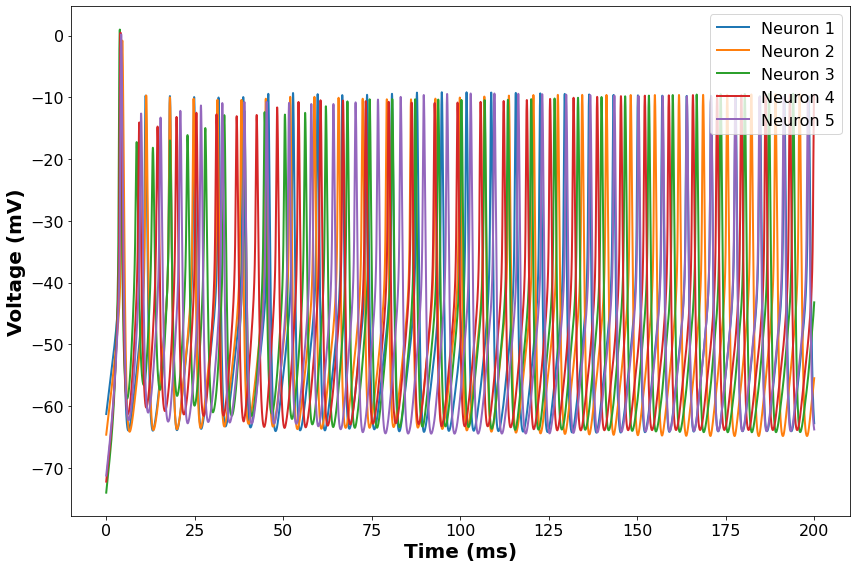

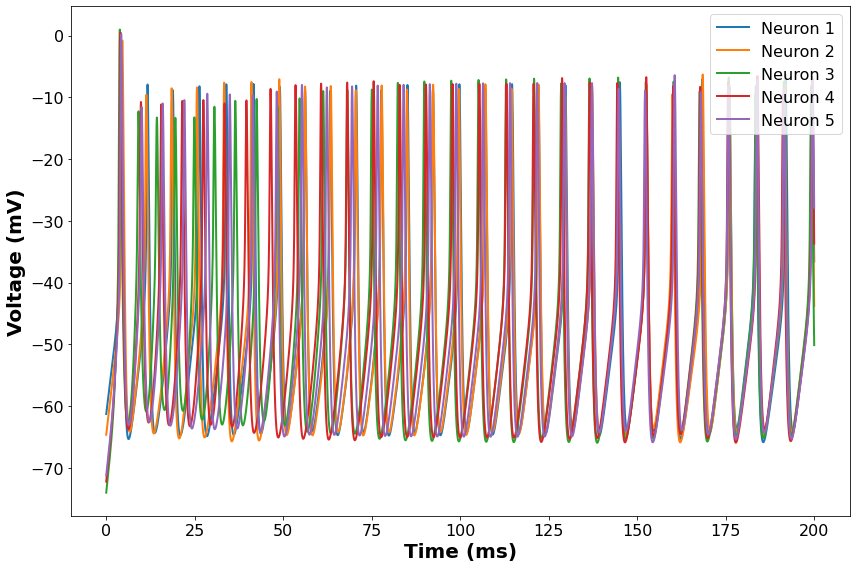

In [72]:
N       = 5
C       = 1.0
Esyn    = 0
K       = 0.1               # global synaptic‐strength so that K·g_static = 0.1
gmin    = 0.0
gmax    = 1.0
A_plus  = A_minus  = 2.0
tau_plus= tau_minus = 10.0
tc      = 3.0               # STDP time window (ms)

t_total = 200.0
dt      = 0.001
t_eval  = np.arange(0, t_total, dt)

# ionic reversal potentials & conductances
EL, ENa, EK, ET = -70.0, 50.0, -90.0, 0.0
gL, gNa, gK, gT = 0.05, 3.0, 5.0, 5.0

# baseline currents (homogeneous here)
#I_stim = np.full(N, 5.0)
I_stim = np.random.uniform(4.84, 5.16, size=N) # Heterogeneous

def h_inf(V):    return 1/(1+np.exp((V+41)/4))
def r_inf(V):    return 1/(1+np.exp((V+84)/4))
def m_inf(V):    return 1/(1+np.exp(-(V+37)/7))
def p_inf(V):    return 1/(1+np.exp(-(V+60)/6.2))
def alpha_h(V):  return 0.128*np.exp(-(V+46)/18)
def beta_h(V):   return 4/(1+np.exp(-(V+23)/5))
def tau_h(V):    return 1/(alpha_h(V)+beta_h(V))
def tau_r(V):    return 28 + np.exp(-(V+25)/10.5)

def ds_dt(V, s, c1=3.0, c2=0.3, VT=-20.0, sigma=0.8):
    return c1*(1-s)/(1+np.exp(-(V-VT)/sigma)) - c2*s

# ionic currents
def I_L(V):     return gL*(V-EL)
def I_Na(V,h):  return gNa*(m_inf(V)**3)*h*(V-ENa)
def I_K(V,h):   return gK*((0.75*(1-h))**4)*(V-EK)
def I_T(V,r):   return gT*(p_inf(V)**2)*r*(V-ET)

# STDP update
def stdp_update(g, delta_t):
    if 0 < delta_t < tc:
        return np.clip(g + A_plus*(1-g)*np.exp(-delta_t/tau_plus), gmin, gmax)
    elif -tc < delta_t <= 0:
        return np.clip(g - A_minus*(g-gmin)*np.exp(delta_t/tau_minus), gmin, gmax)
    else:
        return g

def full_model(t, y, g_matrix):
    V, h, r, s = np.split(y, 4)
    dV = np.zeros(N)
    dh = np.zeros(N)
    dr = np.zeros(N)
    ds = np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i],h[i]) + I_K(V[i],h[i]) + I_T(V[i],r[i])
        # note the K factor here:
        Isyn = K * sum(g_matrix[i,j]*s[j]*(V[i]-Esyn) for j in range(N) if j!=i)/(N-1)
        dV[i] = ( - Iion + I_stim[i] - Isyn )/C
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = ds_dt(V[i], s[i])
    return np.concatenate([dV, dh, dr, ds])

V0 = np.random.uniform(-75,-55, N)
h0 = h_inf(V0)
r0 = r_inf(V0)
s0 = np.zeros(N)
y0 = np.concatenate([V0,h0,r0,s0])

g_static = np.ones((N,N))
np.fill_diagonal(g_static, 0.0)

sol_static = np.zeros((4*N, len(t_eval)))
y = y0.copy()
sol_static[:,0] = y
for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_static)
    y  = y + dy*dt
    sol_static[:,k+1] = y

g_dynamic  = g_static.copy()      # start from same baseline
last_spikes= np.full(N, -1e6)     # far in the past
V_prev      = y0[:N].copy()

Y_stdp = np.zeros((4*N, len(t_eval)))
y = y0.copy()
Y_stdp[:,0] = y

for k,t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_dynamic)
    y  = y + dy*dt

    V = y[:N]

    # threshold‐crossing with positive slope:
    for i in range(N):
        if V_prev[i] < -30 <= V[i] and (V[i]-V_prev[i])>0 and (t - last_spikes[i])>tc:
            # neuron i has just spiked
            for j in range(N):
                if i==j: continue
                # 1) update synapse j -> i  (post = i, pre = j)
                dt_ji = t - last_spikes[j]
                g_dynamic[i,j] = stdp_update(g_dynamic[i,j], dt_ji)
                # 2) update synapse i -> j  (post = j, pre = i)
                dt_ij = last_spikes[j] - t
                g_dynamic[j,i] = stdp_update(g_dynamic[j,i], dt_ij)
            last_spikes[i] = t

    V_prev = V.copy()
    Y_stdp[:,k+1] = y

plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, sol_static[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("Without Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('WithoutSTDPExcitatory_Heterogeneous.png')
plt.show()

plt.figure(figsize=(12,8))
for i in range(N):
    plt.plot(t_eval, Y_stdp[i,:], label=f'Neuron {i+1}', linewidth=2)
#plt.title("With Synaptic Plasticity", fontsize=20, fontweight='bold')
plt.xlabel("Time (ms)", fontsize=20, fontweight='bold')
plt.ylabel("Voltage (mV)", fontsize=20, fontweight='bold')
plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('WithSTDPExcitatory_Heterogeneous.png')
plt.show()


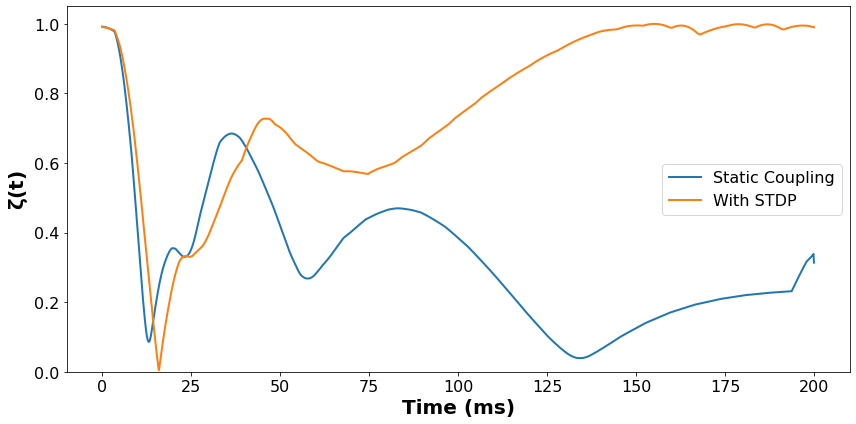

In [73]:
def compute_phases_and_R(V_traces, t_eval, thresh=-30.0):
   
    N, T = V_traces.shape
    phases = np.zeros((N, T))
    
    # 1) detect spike times and mean ISI per neuron
    spike_times = []
    mean_ISI     = np.zeros(N)
    for i in range(N):
        # rising threshold crossings
        idx = np.where((V_traces[i,:-1] < thresh) & (V_traces[i,1:] >= thresh))[0]
        st = t_eval[idx]
        spike_times.append(st)
        if len(st) > 1:
            mean_ISI[i] = np.mean(np.diff(st))
        else:
            mean_ISI[i] = t_eval[-1]  # fallback if only 1 spike

    # 2) build a continuous phase by linear interpolation across an extended spike train
    for i in range(N):
        st = spike_times[i]
        isi = mean_ISI[i]
        # pad beginning and end so we cover [0, t_total]
        ext = np.concatenate(([st[0]-isi], st, [st[-1]+isi]))
        for k in range(len(ext)-1):
            t0, t1 = ext[k], ext[k+1]
            mask = (t_eval >= t0) & (t_eval < t1)
            phases[i,mask] = 2*np.pi * (t_eval[mask] - t0) / (t1 - t0)

    # 3) compute R(t)
    R = np.abs(np.sum(np.exp(1j * phases), axis=0) / N)
    return phases, R

# Extract voltage traces (rows 0..N-1 of your solution arrays)
V_static = sol_static[:N, :]   # shape (N, len(t_eval))
V_stdp   = Y_stdp[:N,   :]

# Compute phases and R
_, R_static = compute_phases_and_R(V_static, t_eval)
_, R_stdp   = compute_phases_and_R(V_stdp,   t_eval)

# 4) plot
plt.figure(figsize=(12,6))
plt.plot(t_eval, R_static, label='Static Coupling', linewidth=2)
plt.plot(t_eval, R_stdp,   label='With STDP',     linewidth=2)
plt.xlabel("Time (ms)",           fontsize=20, fontweight = 'bold')
plt.ylabel(r"$\mathbf{\zeta(t)}$",     fontsize=20, fontweight = 'bold')
plt.ylim(0, 1.05)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('KuramatoExcit_Heterogeneous.png')
plt.show()


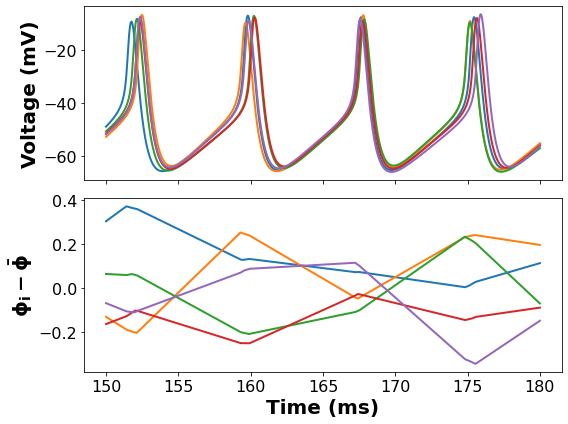

In [6]:
N       = 5
C       = 1.0
Esyn    = 0.0
K       = 0.1
gmin    = 0.0
gmax    = 1.0
A_plus  = A_minus  = 2.0
tau_plus= tau_minus = 10.0
tc      = 3.0               # STDP window (ms)

t_total = 200.0
dt      = 0.001
t_eval  = np.arange(0, t_total, dt)

# Reversal potentials & conductances
EL, ENa, EK, ET = -70.0, 50.0, -90.0, 0.0
gL, gNa, gK, gT = 0.05, 3.0, 5.0, 5.0

# Baseline current
#I_stim = np.full(N, 5.0)
I_stim = np.random.uniform(4.84, 5.16, size=N)

def h_inf(V):    return 1/(1+np.exp((V+41)/4))
def r_inf(V):    return 1/(1+np.exp((V+84)/4))
def m_inf(V):    return 1/(1+np.exp(-(V+37)/7))
def p_inf(V):    return 1/(1+np.exp(-(V+60)/6.2))
def alpha_h(V):  return 0.128*np.exp(-(V+46)/18)
def beta_h(V):   return 4/(1+np.exp(-(V+23)/5))
def tau_h(V):    return 1/(alpha_h(V)+beta_h(V))
def tau_r(V):    return 28 + np.exp(-(V+25)/10.5)

def ds_dt(V, s, c1=3.0, c2=0.3, VT=-20.0, sigma=0.8):
    return c1*(1-s)/(1+np.exp(-(V-VT)/sigma)) - c2*s

# Ionic currents
def I_L(V):     return gL*(V-EL)
def I_Na(V,h):  return gNa*(m_inf(V)**3)*h*(V-ENa)
def I_K(V,h):   return gK*((0.75*(1-h))**4)*(V-EK)
def I_T(V,r):   return gT*(p_inf(V)**2)*r*(V-ET)

# STDP update rule
def stdp_update(g, delta_t):
    if 0 < delta_t < tc:
        return np.clip(g + A_plus*(1-g)*np.exp(-delta_t/tau_plus), gmin, gmax)
    elif -tc < delta_t <= 0:
        return np.clip(g - A_minus*(g-gmin)*np.exp(delta_t/tau_minus), gmin, gmax)
    else:
        return g

def full_model(t, y, g_matrix):
    V, h, r, s = np.split(y, 4)
    dV = np.zeros(N)
    dh = np.zeros(N)
    dr = np.zeros(N)
    ds = np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i],h[i]) + I_K(V[i],h[i]) + I_T(V[i],r[i])
        Isyn = K * sum(g_matrix[i,j]*s[j]*(V[i]-Esyn) for j in range(N) if j!=i)/(N-1)
        dV[i] = ( - Iion + I_stim[i] - Isyn )/C
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = ds_dt(V[i], s[i])
    return np.concatenate([dV, dh, dr, ds])

V0 = np.random.uniform(-75, -55, N)
h0 = h_inf(V0)
r0 = r_inf(V0)
s0 = np.zeros(N)
y0 = np.concatenate([V0, h0, r0, s0])

g_dynamic   = np.ones((N,N))
np.fill_diagonal(g_dynamic, 0.0)
last_spikes = np.full(N, -1e6)
V_prev      = y0[:N].copy()

Y_stdp = np.zeros((4*N, len(t_eval)))
y = y0.copy()
Y_stdp[:,0] = y

for k, t in enumerate(t_eval[:-1]):
    dy = full_model(t, y, g_dynamic)
    y  = y + dy*dt
    V  = y[:N]

    # STDP on upward threshold crossings
    for i in range(N):
        if V_prev[i] < -30 <= V[i] and (t - last_spikes[i]) > tc:
            for j in range(N):
                if i == j: continue
                dt_ji = t - last_spikes[j]
                g_dynamic[i,j] = stdp_update(g_dynamic[i,j], dt_ji)
                dt_ij = last_spikes[j] - t
                g_dynamic[j,i] = stdp_update(g_dynamic[j,i], dt_ij)
            last_spikes[i] = t

    V_prev = V.copy()
    Y_stdp[:,k+1] = y

phi = np.zeros((N, len(t_eval)))
for i in range(N):
    crosses = np.where((Y_stdp[i,:-1] < -30) & (Y_stdp[i,1:] >= -30))[0] + 1
    times   = t_eval[crosses]
    for j in range(len(times)-1):
        t0, t1 = times[j], times[j+1]
        idxs = np.where((t_eval >= t0) & (t_eval < t1))[0]
        phi[i, idxs] = 2*np.pi * (t_eval[idxs] - t0) / (t1 - t0)
    # extend last segment
    if len(times) > 1:
        period = times[-1] - times[-2]
        idxs = np.where(t_eval >= times[-1])[0]
        phi[i, idxs] = 2*np.pi * (t_eval[idxs] - times[-1]) / period

# Center around mean phase
phi_bar = np.angle(np.mean(np.exp(1j*phi), axis=0))
phi_dev = np.angle(np.exp(1j*(phi - phi_bar)))


start = int(150/dt); end = int(180/dt)
t_win = t_eval[start:end]
V_win = Y_stdp[:N, start:end]
phi_win = phi_dev[:, start:end]

fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True)
colors = plt.cm.tab10(np.arange(N))

for i in range(N):
    axes[0].plot(t_win, V_win[i], color=colors[i], lw=2)
axes[0].set_ylabel("Voltage (mV)", fontweight = 'bold', fontsize = '20')
axes[0].tick_params(axis='both', labelsize=16)
#axes[0].set_title("Full order model (150–180 ms)")

for i in range(N):
    axes[1].plot(t_win, phi_win[i], color=colors[i], lw=2)
axes[1].set_xlabel("Time (ms)", fontweight = 'bold', fontsize = '20')
axes[1].set_ylabel(r"$\mathbf{\phi_i - \bar\phi}$", fontsize = '20')
axes[1].tick_params(axis='both', labelsize=16)
#axes[1].set_title("Phase reduced model (150–180 ms)")

plt.tight_layout()
plt.tight_layout()
fig.savefig('voltage_phase_heterogeneous.png')
plt.show()
plt.show()


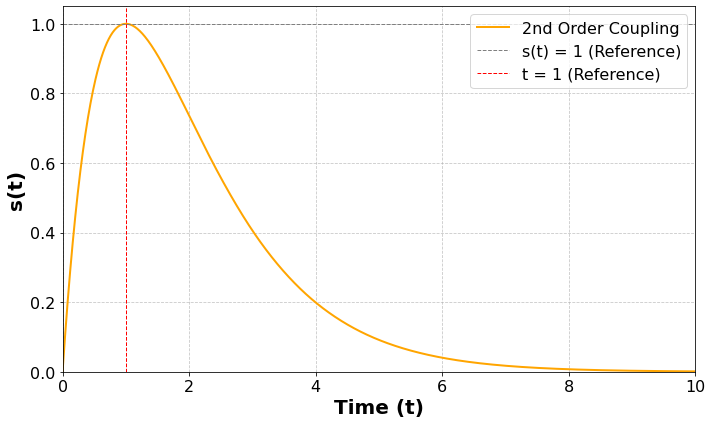

In [92]:
# p0 = 2.7185823035951033
# tauS = 3.043043043043043

p0 = 1
tauS = 1

# Define the second-order system
def dxdt_new(t, x, tau_s):
    s = x[0]
    p = x[1]
    dsdt = -s / tau_s + p / tau_s
    dpdt = -p / tau_s
    return [dsdt, dpdt]

# Time setup
t0 = 0
tfinal = 10
t = np.linspace(t0, tfinal, 1000)
eval_time = tauS

# Initial conditions and constants

x0_new = [0, 2.7185823035951033]

sol2 = solve_ivp(dxdt_new, [t0, tfinal], x0_new, args=(eval_time,), dense_output=True)
s2 = sol2.sol(t)[0]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t, s2, label='2nd Order Coupling', color='orange', linewidth=2)
plt.axhline(1, color='gray', linestyle='--', linewidth=1)
plt.axvline(eval_time, color='red', linestyle='--', linewidth=1)

# Custom legend entries
custom_lines = [
    Line2D([0], [0], color='orange', lw=2),
    Line2D([0], [0], color='gray', lw=1, linestyle='--'),
    Line2D([0], [0], color='red', lw=1, linestyle='--'),
]
legend_labels = [
    '2nd Order Coupling',
    's(t) = 1 (Reference)',
    't = 1 (Reference)',
]

plt.legend(custom_lines, legend_labels, fontsize=16, loc='upper right')

# Formatting
plt.xlabel('Time (t)', fontsize=20, weight='bold')
plt.ylabel('s(t)', fontsize=20, weight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim([0, 10])
plt.ylim([0, 1.05])
plt.tight_layout()
plt.savefig('SynapticModels.png')
plt.show()


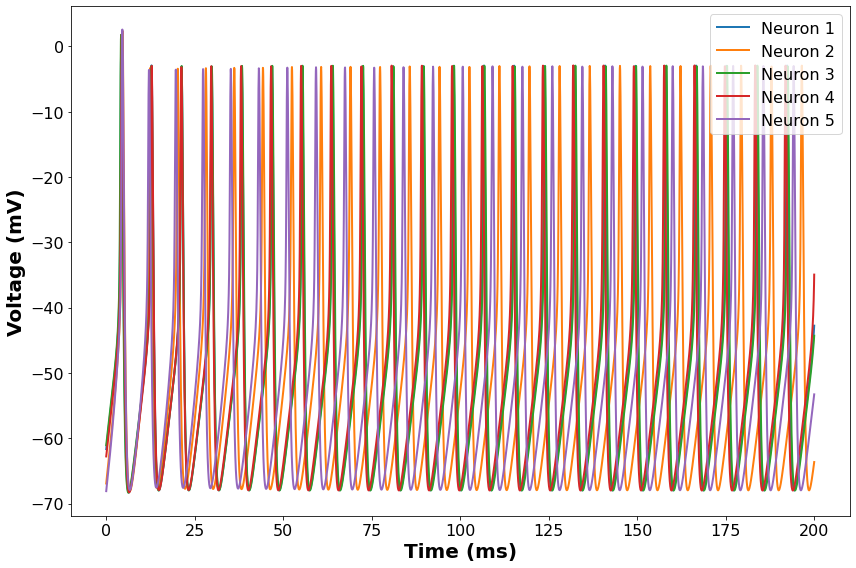

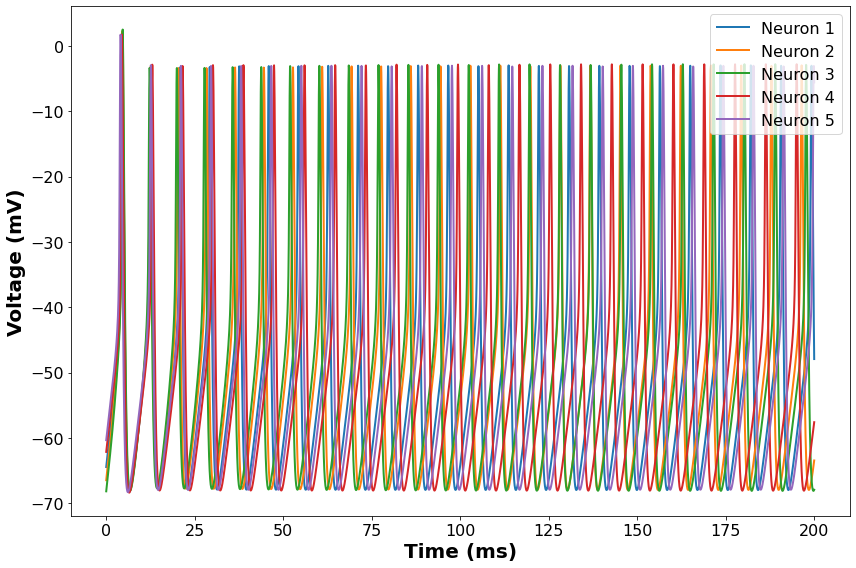

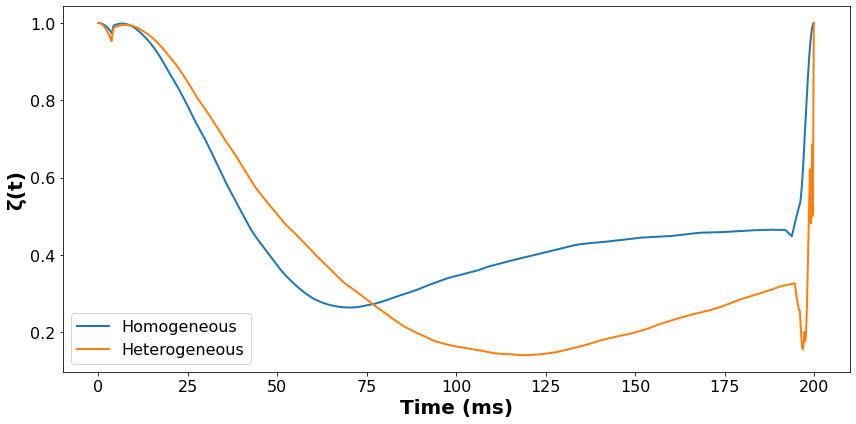

In [118]:
np.random.seed(101)
N       = 5
T       = 200.0      # total time (ms)
dt      = 0.05       # timestep
t_eval  = np.arange(0, T, dt)

C       = 1.0
Esyn    = -80.0      # inhibitory; set to 0.0 for excitatory
K       = 0.1        # global synaptic scale
tauS    = 1.0        # synaptic time constant
p0      = 1.0        # pulse area

EL, ENa, EK, ET = -70.0, 50.0, -90.0, 0.0
gL, gNa, gK, gT = 0.05, 3.0, 5.0, 5.0

g = np.ones((N, N))*0.1
#np.fill_diagonal(g, 0.0)

def h_inf(V):    return 1/(1 + np.exp((V + 41)/4))
def r_inf(V):    return 1/(1 + np.exp((V + 84)/4))
def m_inf(V):    return 1/(1 + np.exp(-(V + 37)/7))
def p_inf(V):    return 1/(1 + np.exp(-(V + 60)/6.2))
def alpha_h(V):  return 0.128 * np.exp(-(V + 46)/18)
def beta_h(V):   return 4/(1 + np.exp(-(V + 23)/5))
def tau_h(V):    return 1/(alpha_h(V) + beta_h(V))
def tau_r(V):    return 28 + np.exp(-(V + 25)/10.5)

def I_L(V):     return gL * (V - EL)
def I_Na(V, h): return gNa * m_inf(V)**3 * h * (V - ENa)
def I_K(V, h):  return gK * (0.75*(1-h))**4 * (V - EK)
def I_T(V, r):  return gT * p_inf(V)**2 * r * (V - ET)

def full_model_2pole(t, y, I_stim):
    V, h, r, s, p = np.split(y, 5)
    dV  = np.zeros(N)
    dh  = np.zeros(N)
    dr  = np.zeros(N)
    ds  = np.zeros(N)
    dp  = np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i],h[i]) + I_K(V[i],h[i]) + I_T(V[i],r[i])
        Isyn = K * np.sum(g[i,:] * s * (V[i]-Esyn)) / (N-1)
        dV[i] = (-Iion + I_stim[i] - Isyn) / C
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = -s[i]/tauS + p[i]/tauS
        dp[i] = -p[i]/tauS
    return np.concatenate([dV, dh, dr, ds, dp])

def simulate_run(I_stim):
    # initial conditions
    V0  = np.random.uniform(-70,-60, N)
    h0  = h_inf(V0)
    r0  = r_inf(V0)
    s0  = np.zeros(N)
    p0v = np.zeros(N)
    y   = np.concatenate([V0, h0, r0, s0, p0v])
    V_prev = V0.copy()

    Y = np.zeros((5*N, len(t_eval)))
    Y[:,0] = y

    threshold = -30.0
    for k, t in enumerate(t_eval[:-1]):
        dy = full_model_2pole(t, y, I_stim)
        y  = y + dy*dt
        V  = y[:N]
        # spike‐triggered pulse
        spk = np.where((V_prev < threshold) & (V >= threshold))[0]
        for i in spk:
            y[4*N + i] += p0/tauS
        V_prev = V.copy()
        Y[:, k+1] = y
    return Y

I_homo = np.full(N, 5.0)
I_hetero = np.random.uniform(4.84, 5.16, size=N)

Y_homo   = simulate_run(I_homo)
Y_hetero = simulate_run(I_hetero)

V_homo   = Y_homo[0:N, :]
V_hetero = Y_hetero[0:N, :]

def extract_spike_times(V_traces, t_eval, threshold=-30.0):
    N, _ = V_traces.shape
    spikes = []
    for i in range(N):
        above = V_traces[i] >= threshold
        idx = np.where((~above[:-1]) & above[1:])[0] + 1
        spikes.append(t_eval[idx])
    return spikes

def compute_phases(spikes, t_eval):
    N = len(spikes)
    M = len(t_eval)
    phi = np.zeros((N, M))
    for i, st in enumerate(spikes):
        if len(st) < 2:
            continue
        idx = 0
        for j, t in enumerate(t_eval):
            while idx+1 < len(st) and t >= st[idx+1]:
                idx += 1
            if t < st[0]:
                phi[i,j] = 2*np.pi * (t/st[0])
            elif idx+1 < len(st):
                dtsp = st[idx+1] - st[idx]
                phi[i,j] = 2*np.pi * (t - st[idx]) / dtsp
            else:
                dtsp = t_eval[-1] - st[-1]
                phi[i,j] = 2*np.pi * (t - st[-1]) / dtsp
    return phi

def kuramoto_order(phi):
    return np.abs(np.sum(np.exp(1j*phi), axis=0) / phi.shape[0])

spikes_homo    = extract_spike_times(V_homo,   t_eval)
spikes_hetero  = extract_spike_times(V_hetero, t_eval)
phi_homo       = compute_phases(spikes_homo,   t_eval)
phi_hetero     = compute_phases(spikes_hetero, t_eval)
z_homo         = kuramoto_order(phi_homo)
z_hetero       = kuramoto_order(phi_hetero)

plt.figure(figsize=(12, 8))
for i in range(N):
    plt.plot(t_eval, V_homo[i], label=f'Neuron {i+1}', linewidth=2)
#plt.title('Voltage Traces — Homogeneous', fontsize=18, fontweight='bold')
plt.xlabel('Time (ms)',      fontsize=20, fontweight='bold')
plt.ylabel('Voltage (mV)',   fontsize=20, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper right')
plt.tight_layout()
plt.savefig('HomoInhibSecondOrder.png')
plt.show()

plt.figure(figsize=(12, 8))
for i in range(N):
    plt.plot(t_eval, V_hetero[i], label=f'Neuron {i+1}', linewidth=2)
#plt.title('Voltage Traces — Heterogeneous', fontsize=18, fontweight='bold')
plt.xlabel('Time (ms)',      fontsize=20, fontweight='bold')
plt.ylabel('Voltage (mV)',   fontsize=20, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper right')
plt.tight_layout()
plt.savefig('HeteroInhibSecondOrder.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(t_eval, z_homo,   label='Homogeneous',   linewidth=2)
plt.plot(t_eval, z_hetero, label='Heterogeneous', linewidth=2)
#plt.title('Kuramoto Order Parameter', fontsize=18, fontweight='bold')
plt.xlabel('Time (ms)',      fontsize=20, fontweight='bold')
plt.ylabel('ζ(t)',     fontsize=20, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='best')
plt.tight_layout()
plt.savefig('KuramotoSecondOrder_Inhib.png')
plt.show()

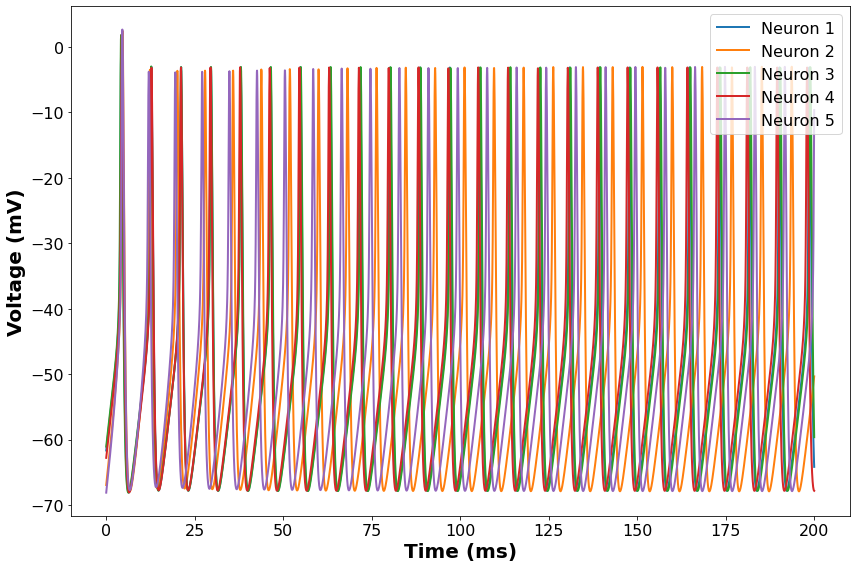

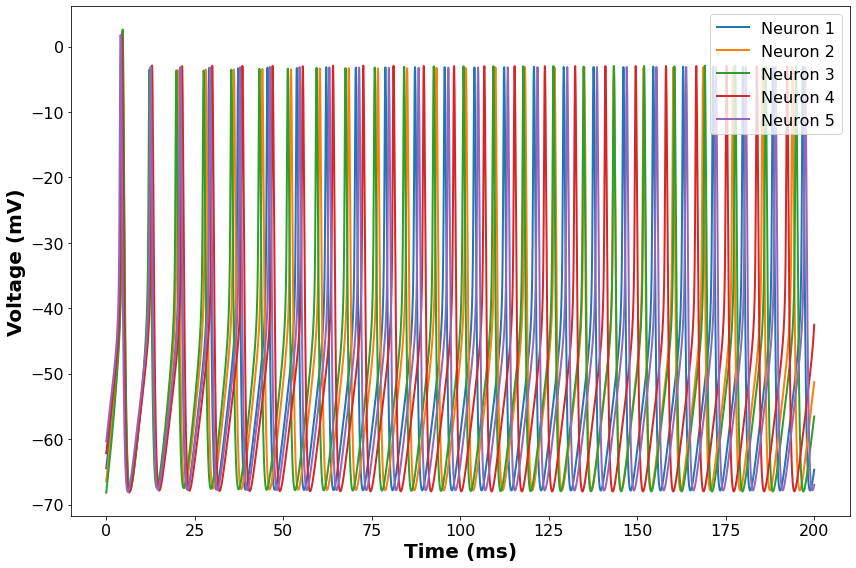

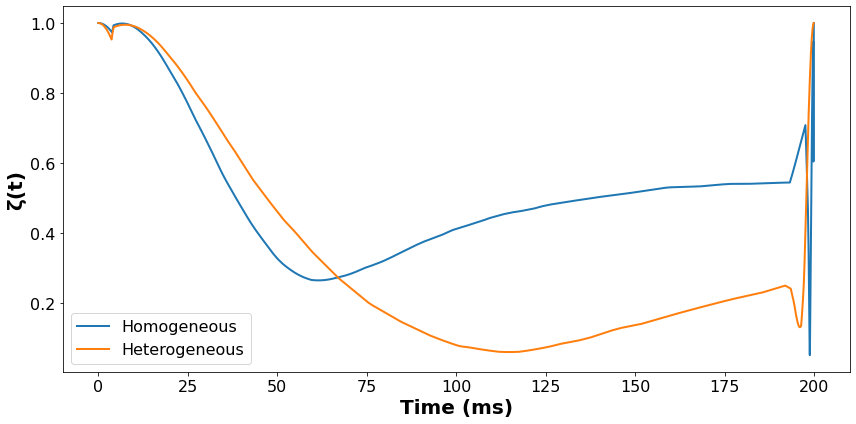

In [119]:
np.random.seed(101)
N       = 5
T       = 200.0      # total time (ms)
dt      = 0.05       # timestep
t_eval  = np.arange(0, T, dt)

C       = 1.0
Esyn    = 0.0      # inhibitory; set to 0.0 for excitatory
K       = 0.1        # global synaptic scale
tauS    = 1.0        # synaptic time constant
p0      = 1.0        # pulse area

EL, ENa, EK, ET = -70.0, 50.0, -90.0, 0.0
gL, gNa, gK, gT = 0.05, 3.0, 5.0, 5.0

g = np.ones((N, N))*0.1
#np.fill_diagonal(g, 0.0)

def h_inf(V):    return 1/(1 + np.exp((V + 41)/4))
def r_inf(V):    return 1/(1 + np.exp((V + 84)/4))
def m_inf(V):    return 1/(1 + np.exp(-(V + 37)/7))
def p_inf(V):    return 1/(1 + np.exp(-(V + 60)/6.2))
def alpha_h(V):  return 0.128 * np.exp(-(V + 46)/18)
def beta_h(V):   return 4/(1 + np.exp(-(V + 23)/5))
def tau_h(V):    return 1/(alpha_h(V) + beta_h(V))
def tau_r(V):    return 28 + np.exp(-(V + 25)/10.5)

def I_L(V):     return gL * (V - EL)
def I_Na(V, h): return gNa * m_inf(V)**3 * h * (V - ENa)
def I_K(V, h):  return gK * (0.75*(1-h))**4 * (V - EK)
def I_T(V, r):  return gT * p_inf(V)**2 * r * (V - ET)

def full_model_2pole(t, y, I_stim):
    V, h, r, s, p = np.split(y, 5)
    dV  = np.zeros(N)
    dh  = np.zeros(N)
    dr  = np.zeros(N)
    ds  = np.zeros(N)
    dp  = np.zeros(N)
    for i in range(N):
        Iion = I_L(V[i]) + I_Na(V[i],h[i]) + I_K(V[i],h[i]) + I_T(V[i],r[i])
        Isyn = K * np.sum(g[i,:] * s * (V[i]-Esyn)) / (N-1)
        dV[i] = (-Iion + I_stim[i] - Isyn) / C
        dh[i] = (h_inf(V[i]) - h[i]) / tau_h(V[i])
        dr[i] = (r_inf(V[i]) - r[i]) / tau_r(V[i])
        ds[i] = -s[i]/tauS + p[i]/tauS
        dp[i] = -p[i]/tauS
    return np.concatenate([dV, dh, dr, ds, dp])

def simulate_run(I_stim):
    # initial conditions
    V0  = np.random.uniform(-70,-60, N)
    h0  = h_inf(V0)
    r0  = r_inf(V0)
    s0  = np.zeros(N)
    p0v = np.zeros(N)
    y   = np.concatenate([V0, h0, r0, s0, p0v])
    V_prev = V0.copy()

    Y = np.zeros((5*N, len(t_eval)))
    Y[:,0] = y

    threshold = -30.0
    for k, t in enumerate(t_eval[:-1]):
        dy = full_model_2pole(t, y, I_stim)
        y  = y + dy*dt
        V  = y[:N]
        # spike‐triggered pulse
        spk = np.where((V_prev < threshold) & (V >= threshold))[0]
        for i in spk:
            y[4*N + i] += p0/tauS
        V_prev = V.copy()
        Y[:, k+1] = y
    return Y

I_homo = np.full(N, 5.0)
I_hetero = np.random.uniform(4.84, 5.16, size=N)

Y_homo   = simulate_run(I_homo)
Y_hetero = simulate_run(I_hetero)

V_homo   = Y_homo[0:N, :]
V_hetero = Y_hetero[0:N, :]

def extract_spike_times(V_traces, t_eval, threshold=-30.0):
    N, _ = V_traces.shape
    spikes = []
    for i in range(N):
        above = V_traces[i] >= threshold
        idx = np.where((~above[:-1]) & above[1:])[0] + 1
        spikes.append(t_eval[idx])
    return spikes

def compute_phases(spikes, t_eval):
    N = len(spikes)
    M = len(t_eval)
    phi = np.zeros((N, M))
    for i, st in enumerate(spikes):
        if len(st) < 2:
            continue
        idx = 0
        for j, t in enumerate(t_eval):
            while idx+1 < len(st) and t >= st[idx+1]:
                idx += 1
            if t < st[0]:
                phi[i,j] = 2*np.pi * (t/st[0])
            elif idx+1 < len(st):
                dtsp = st[idx+1] - st[idx]
                phi[i,j] = 2*np.pi * (t - st[idx]) / dtsp
            else:
                dtsp = t_eval[-1] - st[-1]
                phi[i,j] = 2*np.pi * (t - st[-1]) / dtsp
    return phi

def kuramoto_order(phi):
    return np.abs(np.sum(np.exp(1j*phi), axis=0) / phi.shape[0])

spikes_homo    = extract_spike_times(V_homo,   t_eval)
spikes_hetero  = extract_spike_times(V_hetero, t_eval)
phi_homo       = compute_phases(spikes_homo,   t_eval)
phi_hetero     = compute_phases(spikes_hetero, t_eval)
z_homo         = kuramoto_order(phi_homo)
z_hetero       = kuramoto_order(phi_hetero)

plt.figure(figsize=(12, 8))
for i in range(N):
    plt.plot(t_eval, V_homo[i], label=f'Neuron {i+1}', linewidth=2)
#plt.title('Voltage Traces — Homogeneous', fontsize=18, fontweight='bold')
plt.xlabel('Time (ms)',      fontsize=20, fontweight='bold')
plt.ylabel('Voltage (mV)',   fontsize=20, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper right')
plt.tight_layout()
plt.savefig('HomoExcitSecondOrder.png')
plt.show()

plt.figure(figsize=(12, 8))
for i in range(N):
    plt.plot(t_eval, V_hetero[i], label=f'Neuron {i+1}', linewidth=2)
#plt.title('Voltage Traces — Heterogeneous', fontsize=18, fontweight='bold')
plt.xlabel('Time (ms)',      fontsize=20, fontweight='bold')
plt.ylabel('Voltage (mV)',   fontsize=20, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper right')
plt.tight_layout()
plt.savefig('HeteroExcitSecondOrder.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(t_eval, z_homo,   label='Homogeneous',   linewidth=2)
plt.plot(t_eval, z_hetero, label='Heterogeneous', linewidth=2)
#plt.title('Kuramoto Order Parameter', fontsize=18, fontweight='bold')
plt.xlabel('Time (ms)',      fontsize=20, fontweight='bold')
plt.ylabel('ζ(t)',     fontsize=20, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='best')
plt.tight_layout()
plt.savefig('KuramotoSecondOrder_Excit.png')
plt.show()